## 犬と猫を分類するモデルを構築

### 1. 画像の読み込み

まずは簡単に画像の読み込みの方法を紹介します。

In [1]:
import onnx

In [2]:
import warnings
warnings.filterwarnings('ignore')

`train` のフォルダに入っている画像を読み込みます。
`glob` を利用すると簡単にファイルを検索できます。

In [3]:
from glob import glob

In [4]:
dog_filepaths = glob('train/dog/*.jpg')
cat_filepaths = glob('train/cat/*.jpg')

In [5]:
# 先頭から３件の表示
dog_filepaths[:3]

['train/dog/63.jpg', 'train/dog/77.jpg', 'train/dog/88.jpg']

In [6]:
# 先頭から３件の表示
cat_filepaths[:3]

['train/cat/63.jpg', 'train/cat/77.jpg', 'train/cat/88.jpg']

では、その中の画像１枚にまず焦点を当てて取り扱い方を見ていきましょう。

Python では Pillow というパッケージで簡単に画像を扱うことができます。込み入った処理は OpenCV を使うと良いでしょう。

今回は単純な読み込み程度ですので Pillow でOKです。

In [7]:
# Windows
# pip install Pillow    or   python -m pip install Pillow

# macOS
!pip3 install Pillow

In [8]:
from PIL import Image

In [9]:
# 画像の読み込み（犬の１番目の画像）
img = Image.open(dog_filepaths[0])

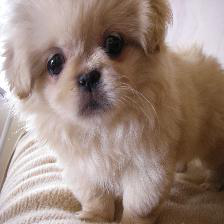

In [10]:
img

In [11]:
# 型の確認
type(img)

PIL.JpegImagePlugin.JpegImageFile

上記の通り、Pillow 独自の方を持っているため、計算で扱う場合には numpy の ndarray に変換しておきましょう。

In [12]:
import numpy as np

In [13]:
# numpy の形式に変換
img = np.array(img)

In [14]:
# 変換後の img での型の確認
type(img)

numpy.ndarray

In [15]:
# サイズの確認
img.shape

(224, 224, 3)

In [16]:
# データ型の確認 => unsigned int 8 => 0~255 の整数で表現される
img.dtype

dtype('uint8')

In [17]:
# （必要に応じて）数値の確認
img

array([[[252, 255, 253],
        [252, 255, 253],
        [254, 255, 255],
        ...,
        [203, 195, 208],
        [202, 194, 207],
        [202, 194, 207]],

       [[252, 255, 253],
        [252, 255, 253],
        [253, 255, 254],
        ...,
        [203, 195, 208],
        [202, 194, 207],
        [202, 194, 207]],

       [[252, 255, 253],
        [252, 255, 253],
        [253, 255, 254],
        ...,
        [204, 196, 209],
        [203, 195, 208],
        [203, 195, 208]],

       ...,

       [[179, 164, 161],
        [165, 150, 147],
        [173, 159, 156],
        ...,
        [ 78,  57,  38],
        [ 69,  48,  29],
        [ 77,  56,  37]],

       [[175, 161, 158],
        [167, 153, 150],
        [169, 155, 154],
        ...,
        [ 78,  57,  38],
        [ 69,  48,  29],
        [ 79,  58,  39]],

       [[163, 149, 146],
        [172, 158, 157],
        [168, 154, 153],
        ...,
        [ 78,  57,  38],
        [ 70,  49,  30],
        [ 80,  59,  40]]

### 2. クラスラベルの割り振り

画像の読み込み方がわかったため、クラスのラベルを割り振っていきましょう。

In [18]:
# 入力値:x, 目標値: t
x, t = [], []

In [19]:
# 犬
for filepath in dog_filepaths:
    img = Image.open(filepath)
    img = np.array(img)
    x.append(img)
    t.append(np.array(0))  # 犬は 0 とする

In [20]:
# 猫
for filepath in cat_filepaths:
    img = Image.open(filepath)
    img = np.array(img)
    x.append(img)
    t.append(np.array(1))  # 猫は 0 とする

In [21]:
# 格納された枚数
len(x), len(t)

(300, 300)

In [22]:
# 全体を numpy の形式に変換
x = np.array(x)  # f は float32
t = np.array(t)  # i は int32

In [23]:
# 300(枚), 224(height), 224(width), 3(channels)
x.shape

(300, 224, 224, 3)

In [24]:
t.shape

(300,)

x の値の範囲を正規化しておくと学習が効率的に進むことが多いため、こちらも行なっておきましょう。学習係数などを調整する場合など、必ず必要ではありません。

In [25]:
# 特徴量の正規化 (0~1の範囲に)
x = x / 255

### 3. 訓練データと検証データに分割

tensorflow では訓練データ (train) と検証データ (val) を分ける機能がないため、scikit-learn の `train_test_split` を利用します。

なお、テストデータ (test) は私の手元にしかないため、手持ちのデータの中で以下にテストデータを模擬的に表現できるかのために検証データがあります。精度を高めたいときには**交差検証法 (cross validation)** も選択肢としてあるため、こちらも必要であれば挑戦してみましょう。

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# train : val = 0.7 : 0.3 の割合で分割する
train_x, val_x, train_t, val_t = train_test_split(x, t, train_size=0.7, random_state=0)

In [28]:
# サイズの確認（訓練データ）
train_x.shape, train_t.shape

((210, 224, 224, 3), (210,))

In [29]:
# サイズの確認（検証データ）
val_x.shape, val_t.shape

((90, 224, 224, 3), (90,))

### 4. モデルを定義

今回は非常にシンプルな構成の CNN でモデルを構築します。あまり良い精度が出ないようにしてあるため、ここのモデルの構造を工夫して精度を高めましょう。

ヒント
- VGG, ResNet, MobileNet
- ファインチューニング

複雑なモデルを構築する場合には GPU がないと遅い場合もあるため、[こちらの手順](https://www.kikagaku.ai/tutorial/guide_for_beginners/learn/platform_environment) を参考に Google Colab を使ってみると良いでしょう。

In [30]:
import tensorflow as tf

In [31]:
# バージョンの情報
tf.__version__

'2.0.0'

モデル構築の際に乱数のシードも固定しておきましょう。

In [32]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) #　random関数のシードを固定
    np.random.seed(seed) #numpyのシードを固定
    tf.random.set_seed(seed) #tensorflowのシードを固定

In [33]:
# シードの固定を実行
reset_seed()

tensorflow のモデルの定義に必要なモジュールを読み込みます

In [34]:
from tensorflow.keras import models, layers

以下のようなモデルを定義していきましょう。

- Original: (224, 224, 3)
- => Convolution (Relu) => (224, 224, 6)
- => Half Pooling => (112, 112, 6)
- => ベクトル化 (112×112×6)
- => 全結合層 (112×112×6 => 100), Relu
- => 全結合層 (100 => 2), Softmax

In [35]:
# モデルの定義
model = models.Sequential([
    # Convolution
    layers.Conv2D(3, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    # Pooling
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    # ベクトル化 (Flatten)
    layers.Flatten(),
    # 全結合層
    layers.Dense(100, activation='relu'),
    # 全結合層
    layers.Dense(2, activation='softmax') 
])





In [59]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
#DataRoaderに対し、部分分割するために使用する
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'torch'

In [58]:
!git clone https://github.com/kuangliu/pytorch-cifar.git pytorch-cifar2
%cd pytorch-cifar2/
!mv models ../
%cd ..
from models import *

Cloning into 'pytorch-cifar2'...
remote: Enumerating objects: 330, done.
remote: Total 330 (delta 0), reused 0 (delta 0), pack-reused 330
Receiving objects: 100% (330/330), 74.58 KiB | 276.00 KiB/s, done.
Resolving deltas: 100% (165/165), done.
/Users/takekazukitagishi/Desktop/情報学館授業資料/s２/特論７/univ_tokyo_2020/tensorflow/pytorch-cifar2
/Users/takekazukitagishi/Desktop/情報学館授業資料/s２/特論７/univ_tokyo_2020/tensorflow


ModuleNotFoundError: No module named 'torch'

### 5. モデルの学習

Tenrsoflow では定義したモデルをコンパイルする必要がありました。最適化のアルゴリズムを確率的勾配降下法 (SGD) として選択します。

ここのアルゴリズムの選択と学習係数の設定も精度向上のポイントですので、[こちらの記事](https://www.tensorflow.org/guide/keras/train_and_evaluate) などを参考にしながら進めてみましょう。

In [36]:
# モデルのコンパイル
model.compile(
    optimizer='SGD',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# モデルの学習
history = model.fit(
    train_x, train_t,
    batch_size=16,
    epochs=10,
    validation_data=(val_x, val_t)
)

Train on 210 samples, validate on 90 samples
Epoch 1/10
210/210 [==============================] - 2s 11ms/sample - loss: 0.7158 - accuracy: 0.5333 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/10
210/210 [==============================] - 2s 8ms/sample - loss: 0.6827 - accuracy: 0.5857 - val_loss: 0.6975 - val_accuracy: 0.5333
Epoch 3/10
210/210 [==============================] - 2s 8ms/sample - loss: 0.6723 - accuracy: 0.6238 - val_loss: 0.7179 - val_accuracy: 0.5333
Epoch 4/10
210/210 [==============================] - 2s 7ms/sample - loss: 0.6657 - accuracy: 0.6000 - val_loss: 0.6976 - val_accuracy: 0.5222
Epoch 5/10
210/210 [==============================] - 1s 7ms/sample - loss: 0.6593 - accuracy: 0.6857 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 6/10
210/210 [==============================] - 2s 7ms/sample - loss: 0.6317 - accuracy: 0.6667 - val_loss: 0.7259 - val_accuracy: 0.4778
Epoch 7/10
210/210 [==============================] - 2s 7ms/sample - loss: 0.6387 - accur

train に関して accuracy が 0.76, validation に関しては accuracy が 0.49 となっており、**過学習 (overfitting)** が生じていることがわかります。

この辺りも踏まえて、予測の精度を上げられるように色々な手法に挑戦してみましょう。比較的簡単なところでは以下を調整してみると良いでしょう。

- モデルの構成（VGG, ResNet, MobileNet など）
- ファイチューニング
- 最適化アルゴリズムの選択
- 学習係数

# 課題

## モデルを定義

In [ ]:
!git clone https://github.com/kuangliu/pytorch-cifar.git pytorch-cifar2
%cd pytorch-cifar2/
!mv models ../
%cd ..
from models import *

In [ ]:
!ls

In [ ]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        
        # Convolutional layers
                            #Init_channels, channels, kernel_size, padding) 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 細かくみていく 
        
        # Pooling layers
        #kernel-size=2, stride=2
        self.pool = nn.MaxPool2d(2,2) # convolution　細かく poolingは大まかに
        
        # FC layers
        # Linear layer (64x4x4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Linear Layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        #ELU(x)=max(0,x)+min(0,α∗(exp(x)−1))
        #ReLU関数、ただし負領域では-α（デフォルト -1.0)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x))) # elu: lump関数
        
        
        # Flatten the image
        x = x.view(-1, 64*4*4) #64*4*4の大きさに変換
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# model = CNNNet()
# model = RegNetX_200MF()
# model = DPN92()
# model = VGG16()
model = ResNet18()
print(model)

# Move tensors to GPU is CUDA is available
if train_on_gpu:
    model.cuda()

In [ ]:
# Specify the Loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## モデルを学習

In [ ]:
# number of epochs to train the model
n_epochs = 25 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

### 5. モデルの保存

推論にて使用するために学習済みモデルをファイルに出力しましょう。

In [38]:
# HDF5 という形式で保存（TensorFlowではこちらを用いるようです）
model.save('dog_cat_cnn.h5')

これで作業フォルダの中に `dog_cat_cnn.h5` というファイルが出力できていれば成功です。

### 6. 学習済みモデルで推論

学習に関しては、上記までで終了となりますが、この後の推論 (inference) サーバーへデプロイの前に保存した学習済みモデルを用いた推論の方法について試しておきましょう。

In [39]:
from tensorflow.keras.models import load_model

In [40]:
# 保存した学習済みモデルを読み込み
model_inference = load_model('dog_cat_cnn.h5')

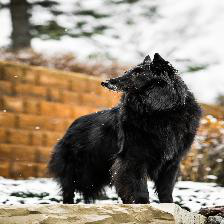

In [41]:
img = Image.open('train/dog/1.jpg')
img

In [42]:
x = np.array(img, 'f')  # float32 に変換
x.shape

(224, 224, 3)

推論時は (224, 224, 3) ではなく、1 サンプルでも (1, 224, 224, 3) としておく必要があります。

In [43]:
# np.newaxis で次元をひとつ追加
x = x[np.newaxis]
x.shape

(1, 224, 224, 3)

予測値は `predict` で求められます。ただし、返ってくる結果はラベルの値ではなく、それぞれのクラスに属する確率です。これを**信頼度 (confidence)** といいます。

In [44]:
y_prob = model_inference.predict(x)[0]
y_prob

array([0.03222039, 0.9677796 ], dtype=float32)

信頼度が最も高いクラスを選択します。

In [45]:
y = np.argmax(y_prob)
y

1

犬が 0 番目であったため、正しく予測できていることがわかります。予測の流れはここまでとなります。

### 7. ONNX形式で出力

ONNX は TensorFlow や PyTorch 問わず、モデルの形式を標準化するプロジェクトです。  
最近では、こちらの形式に統一しておくほうが汎用性が高くなっているため、推論サーバーでは ONNX 形式を使用します。

onnxruntime では通常よりも速度が速いと言われています。

In [1]:
import tensorflow as tf

In [9]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', input_shape = (150,150,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2,padding='same'),
    tf.keras.layers.Dropout(0.25),
    
    
    
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2,padding='same'),
    tf.keras.layers.Dropout(0.20),
    
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2,padding='same'),
    tf.keras.layers.Dropout(0.25),
    
    
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2,padding='same'),
    tf.keras.layers.Dropout(0.20),
    
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3,padding='same'),
    tf.keras.layers.Dropout(0.25),
    
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.50),
    tf.keras.layers.Dense(1,activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 38, 38, 32)       

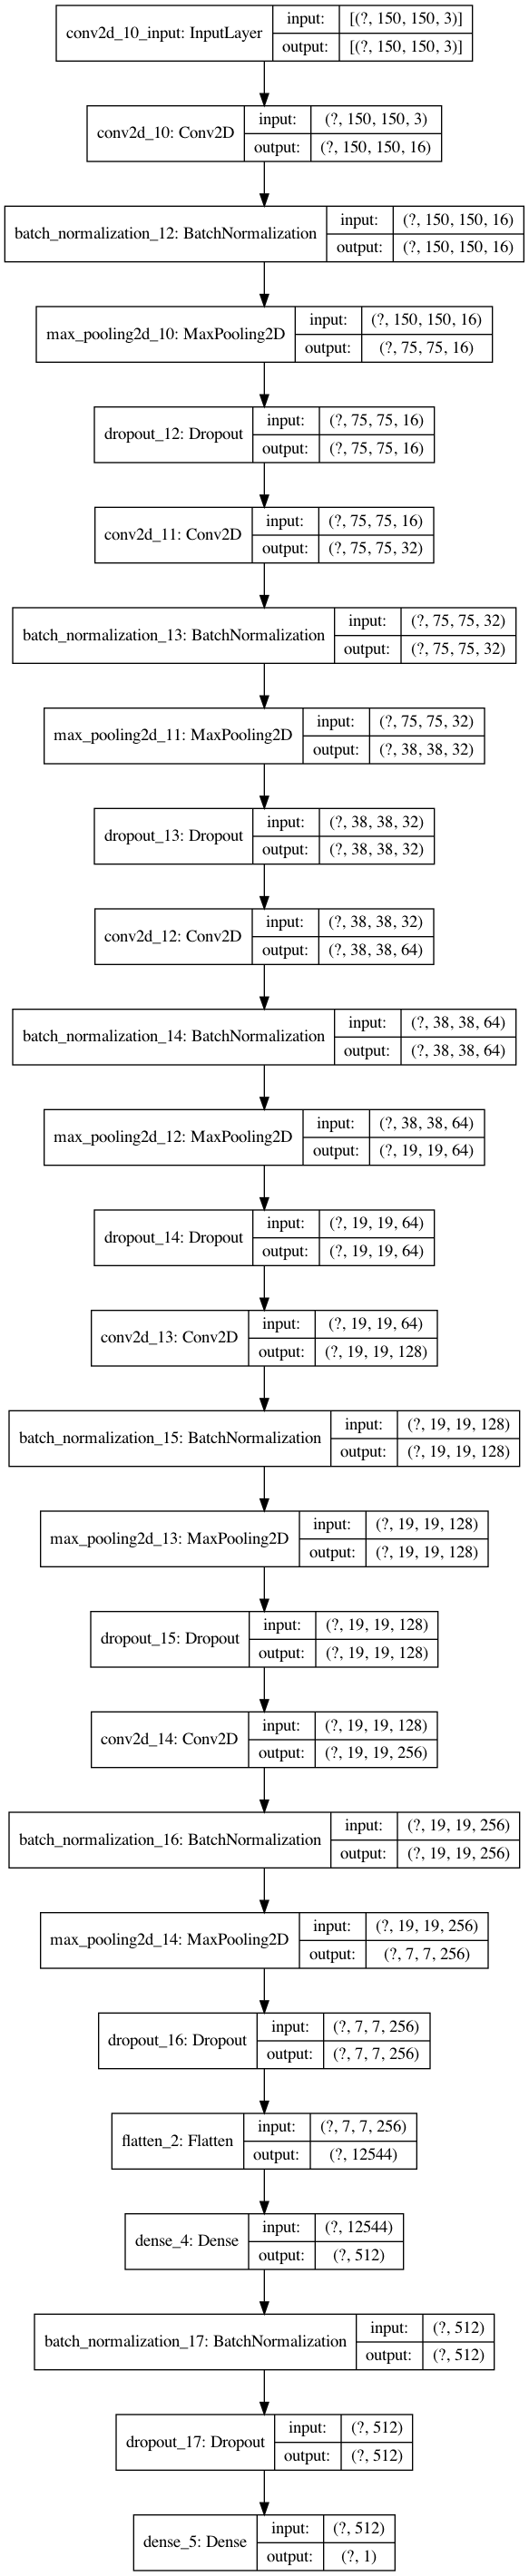

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.load_weights('./results/model.h5')

ValueError: Shapes (12544, 512) and (256, 512) are incompatible

In [22]:
256 * 512 / 4096


32.0

In [ ]:
# Windows
# !pip install onnxruntime   or   !python -m pip install onnxruntime

# macOS
#!pip3 install onnxruntime

In [ ]:
import sys
import pprint
pprint.pprint(sys.path)


import onnxruntime
onnxruntime.__version__

# Windows
# !pip install keras2onnx  or   !python -m pip install keras2onnx

# macOS
#!pip3 install keras2onnx

import keras2onnx
keras2onnx.__version__

# Keras -> ONNX の変換
onnx_model = keras2onnx.convert_keras(model, model.name)

# モデルを保存
keras2onnx.save_model(onnx_model, 'dog_cat_cnn.onnx')

# モデルの読み込み
session = onnxruntime.InferenceSession('dog_cat_cnn.onnx')

# 推論に必要な構造の抽出
session.get_modelmeta()
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

input_name, output_name

# 推論
y_probs = session.run([output_name], {input_name: x})[0]
y_probs

# ラベル
y = np.argmax(y_prob)
y